In [1]:
import argparse
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from jax.experimental.ode import build_odeint
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive

In [164]:
# (Could easily generalize this to flows between compartments)
def dx_dt(x, t, beta, gamma):
    """
    SIR equations. Real positive parameters `beta`, `gamma`,
    describe the infection rate and recovery rate.
    """
    S = x[0]
    I = x[1]
    R = x[2]
    dS_dt = - beta * S * I
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I
    return np.stack([dS_dt, dI_dt, dR_dt])

SIR_int = build_odeint(dx_dt, rtol=1e-5, atol=1e-3, mxstep=500)

def myBeta(mean, concentration):
    alpha = mean * concentration
    beta = concentration - alpha
    return dist.Beta(alpha, beta)

def model_deterministic(ts, beta=2.5/14, gamma=1.0/14, S=0.99, I=0.01):
    x_init = np.array([S, I, 1-S-I])
    theta = np.array([beta, gamma])
    return SIR_int(x_init, ts, *theta)


def SIR_stochastic(dt=1.0, 
                   steps=50,
                   X_init=np.array([0.99, 0.01, 0.00])*1e5):
    
    N = X_init.sum()
    
    beta_mean = 3/14
    beta_scale = 1
    
    gamma_mean = 1/14
    gamma_scale = 0.5
        
    obs_rate = 0.1
    obs_concentration = 400
    
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(low=0., 
                             loc=np.array([beta_mean, gamma_mean]),
                             scale=np.array([beta_scale, gamma_scale])))

    compartments = len(X_init)
    
    j = 0
    def advance(X, theta):
        nonlocal j
        beta, gamma = theta
        S, I, R = X

        #print(S, I, R, N)
        
        rate_SI = beta * I / N
        rate_IR = gamma
                
        p_SI = 1 - np.exp(-rate_SI * dt)
        p_IR = 1 - np.exp(-rate_IR * dt)
                
        n_SI = numpyro.sample(f'n_SI_{j}', dist.Binomial(S, p_SI))
        n_IR = numpyro.sample(f'n_IR_{j}', dist.Binomial(I, p_IR))
        
        #n_SI = numpyro.sample(f'n_SI_{j}', dist.Poisson(S * rate_SI * dt))
        #n_IR = numpyro.sample(f'n_IR_{j}', dist.Poisson(I * rate_IR * dt))

        j = j + 1
        
        delta = np.array([n_SI, n_IR])
        flow = np.array([-n_SI, n_SI - n_IR, n_IR])
        X_new = X + flow

        return X_new, delta
    

    X_rows = [None] * steps
    delta_rows = [None] * (steps - 1)
    
    X_rows[0] = X_init
    for i in range(steps - 1):
        X_rows[i+1], delta_rows[i] = advance(X_rows[i], theta)
        
    X = np.vstack(X_rows)
    delta = np.vstack(delta_rows)
    
    n_SI = delta[:,0]
    numpyro.deterministic("X", X)
        
    y = numpyro.sample('y', myBeta(obs_rate * n_SI, obs_concentration))

    return X, y


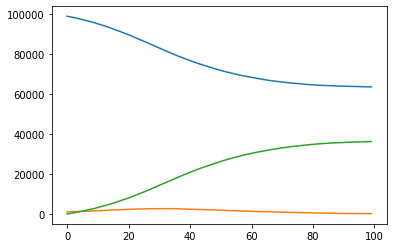

In [166]:
with numpyro.handlers.seed(rng_seed=1):
    X, y = SIR_stochastic(dt=1.0,steps=100)

plt.plot(X)
plt.show()

In [ ]:
def model1(ts=ts):
    '''
    Model with random parameters, deterministic dynamics, and Beta observations
    '''
    x_init = np.array([0.99, 0.01, 0.00])

    beta_mean = 4
    beta_scale = 1
    
    gamma_mean = 2
    gamma_scale = 0.5
        
    obs_rate = 0.1
    obs_concentration = 400
    
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(low=0., 
                             loc=np.array([beta_mean, gamma_mean]),
                             scale=np.array([beta_scale, gamma_scale])))

    x = SIR_int(x_init, ts, *theta)
    numpyro.deterministic("x", x)
    
    xx = np.vstack([x_init, x])
    new_infections = np.maximum(np.diff(xx[:,1], axis=0), 0)
    
    y = numpyro.sample('y', myBeta(obs_rate*new_infections, obs_concentration))

    return x, y

def test_model1(i):
    ts = np.linspace(0.0, 5.0, 50)
    with numpyro.handlers.seed(rng_seed=i):
        x, y = model1(ts)

    y_cum = np.cumsum(y)

    plt.plot(ts, x)
    plt.scatter(ts, y_cum/0.2)
    plt.show()

for i in range(20):
    test_model1(i)

In [ ]:
x.shape

In [ ]:
# def model2(T):
#     '''
#     Model with random parameters and stochastic dynamics
#     Now has discrete time step of 1 day
#     '''
#     x_init = np.array([0.99, 0.01, 0.00])

#     beta_mean = 4
#     beta_scale = 1
    
#     gamma_mean = 2
#     gamma_scale = 0.5
        
#     theta = numpyro.sample(
#         "theta",
#         dist.TruncatedNormal(low=0., 
#                              loc=np.array([beta_mean, gamma_mean]),
#                              scale=np.array([beta_scale, gamma_scale])))


#     # Simulate the dynamics for T time steps
#     for t in range(T):        
#         x = SIR_int(x_init, ts, *theta)
#         numpyro.deterministic("x", x)
    
#     return x

In [ ]:
# Samples from the prior predictive

ts = np.linspace(0.0, 5.0, 20)
prior_predictive = Predictive(model1, posterior_samples = {}, num_samples=100)
samples = prior_predictive(PRNGKey(2), ts)
mean = samples['x'].mean(axis=0)
pi = np.percentile(samples['x'], (10, 90), axis=0)

#plt.plot(ts, mean[:,1], color='g')
plt.plot(ts, mean[:,1], color='r')
plt.plot(ts, mean[:,2], color='b')

plt.scatter(ts, samples['y'])

#plt.fill_between(ts, pi[0, :, 0], pi[1, :, 0], color="g", alpha=0.1)
plt.fill_between(ts, pi[0, :, 1], pi[1, :, 1], color="r", alpha=0.1)
plt.fill_between(ts, pi[0, :, 2], pi[1, :, 2], color="b", alpha=0.1)

plt.legend(['infected', 'removed'])

In [ ]:
# run the deterministic model
ts = np.linspace(0.0, 200.0, 100)
gamma = 1/10

R0_vals = [1.4, 1.5, 2.0, 2.5, 3.0]

n = len(R0_vals)
color=iter(cm.Set1(np.linspace(0,1,n)))

plt.figure(figsize=(8,5))
for R0 in R0_vals:
    beta = R0*gamma
    c = next(color)
    x = model_deterministic(ts, beta, gamma)
    plt.plot(ts, x[:,1:], color=c)

plt.ylim([0,1])
plt.legend(plt.gca().lines[::2], R0_vals)
plt.show()

In [ ]:
ts.shape
samples['y'].shape

In [ ]:
def myBeta(mean, concentration):
    alpha = mean * concentration
    beta = concentration - alpha
    return dist.Beta(alpha, beta)

d = myBeta(0.4, 500)
x = np.linspace(0, 1, 100)
plt.plot(x, np.exp(d.log_prob(x)))

with numpyro.handlers.seed(rng_seed=1):
    x = numpyro.sample('x', d, sample_shape=(1000,))

plt.hist(x, density=True)
plt.show()

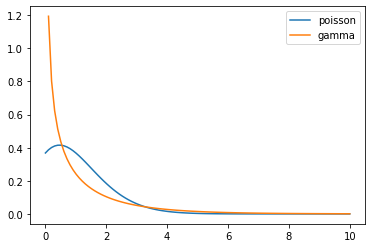

In [69]:
rate = 1
d_pois = dist.Poisson(rate)
beta = 0.5
d_gamma = dist.Gamma(rate*beta, beta)
#d_normal = dist.Normal(rate, np.sqrt(rate))
# with numpyro.handlers.seed(rng_seed=1):
#     x = numpyro.sample('x', d, sample_shape=(1000,))

x = np.linspace(0, 10, 100)
plt.plot(x, np.exp(d_pois.log_prob(x)))
plt.plot(x, np.exp(d_gamma.log_prob(x)))
#plt.plot(x, np.exp(d_normal.log_prob(x)))
plt.legend(['poisson', 'gamma', 'normal'])